In [46]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'..')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import numpy as np
import streamlit as st
from copy import deepcopy as dc
import pandas as pd
from pathlib import Path
from src.label_checker_automata import LabelCheckerAutomata
from src.caption import Caption
import src.utils as utils

## Load data and all labels

In [48]:
data_dir = Path("../data/cropped_coas/out/images")

labels = []

for image_fn in data_dir.iterdir():
    if image_fn.suffix == ".jpg" and not image_fn.name.startswith("."):
        labels.append("_".join(image_fn.stem.split("_")[1:]))

df = pd.DataFrame.from_dict({
    "label": labels,
})
df

,label
0,G A per chevron
1,S O 3 crosses formy
2,A S crampon per fess
3,G A cross
4,A G fleur-de-lis
...,...
3060,A G qtly
3061,O GA lion _ label
3062,G plain
3063,A G saltire engrailed


# Duplicates in labels: Histogram of labels

In [49]:
def plot_bar_chart(data):
    labels, values = zip(*data)
    indexes = np.arange(len(labels))
    width = 0.5

    plt.rcParams["figure.figsize"] = (20, 10)
    plt.bar(indexes, values, width)
    plt.xticks(indexes, labels, rotation='vertical', fontsize=15)
    plt.show()


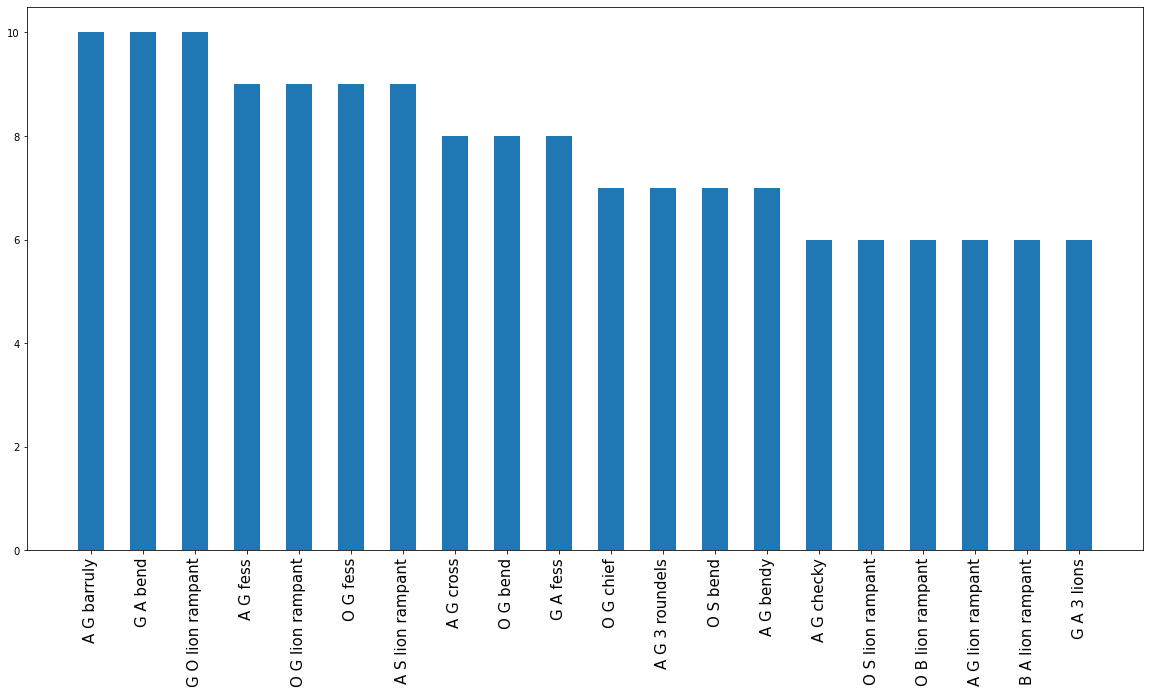

2385

In [50]:
import matplotlib.pyplot as plt
from collections import Counter

x = Counter(labels)
plot_bar_chart(x.most_common(20))
# x.most_common(20)
len(x)

In [51]:
elems, count = np.unique(labels, return_counts=True)
output = []
counter=0
for l, n in zip(elems, count):
    if n > 1:
        print(f'{n} : "{l}"')
        counter+=1


2 : " 3 fleurs-de-lis_ 3 lions passt guard_ =_ =  {BO, GO}"
2 : " 3 fleurs-de-lis_ 3 lions passt guard_ =_ = _ book  {BO, GO_ A}"
2 : " 3 fleurs-de-lis_ lion   {BO, GO}"
2 : " blank shield"
2 : " castle_ lion_ =_ =  {GO, AP}"
2 : " ps[4 pales_ eagle_ =_ =]  {OG, AS}"
2 : "A B 3 bars"
2 : "A B 3 bends"
4 : "A B barruly"
4 : "A B barry"
2 : "A B bend"
3 : "A B bendy"
3 : "A B checky"
4 : "A B chief"
3 : "A B fess"
2 : "A B fess undy"
3 : "A B lion cr."
5 : "A B lion rampant"
3 : "A B lozengy"
2 : "A B pallety"
2 : "A B paly"
2 : "A B qtly"
2 : "A B vairy"
4 : "A BG barry _ border"
4 : "A G 2 bars"
2 : "A G 2 lions rampant addorsed"
4 : "A G 3 axes"
2 : "A G 3 bars"
4 : "A G 3 chevrons"
2 : "A G 3 eagles"
4 : "A G 3 escutcheons"
2 : "A G 3 flanchis"
2 : "A G 3 fleurs-de-lis p.n."
2 : "A G 3 lions"
3 : "A G 3 roses"
2 : "A G 3 roses in bend"
7 : "A G 3 roundels"
2 : "A G 3 waterlily leaves inv"
10 : "A G barruly"
2 : "A G barry"
3 : "A G bend"
2 : "A G bend of lozenges"
7 : "A G bendy"
2 :

In [26]:
count.sum()

3065

In [25]:
print(f'There are {counter} repeated labels out of {len(elems)} total labels')

There are 352 repeated labels out of 2385 total labels


In [33]:
import re

voc = []
for label in labels:
    ws = re.findall(r'\w+', label)
    for w in ws:
        voc.append(w)
len(voc), len(set(voc))

(16530, 987)

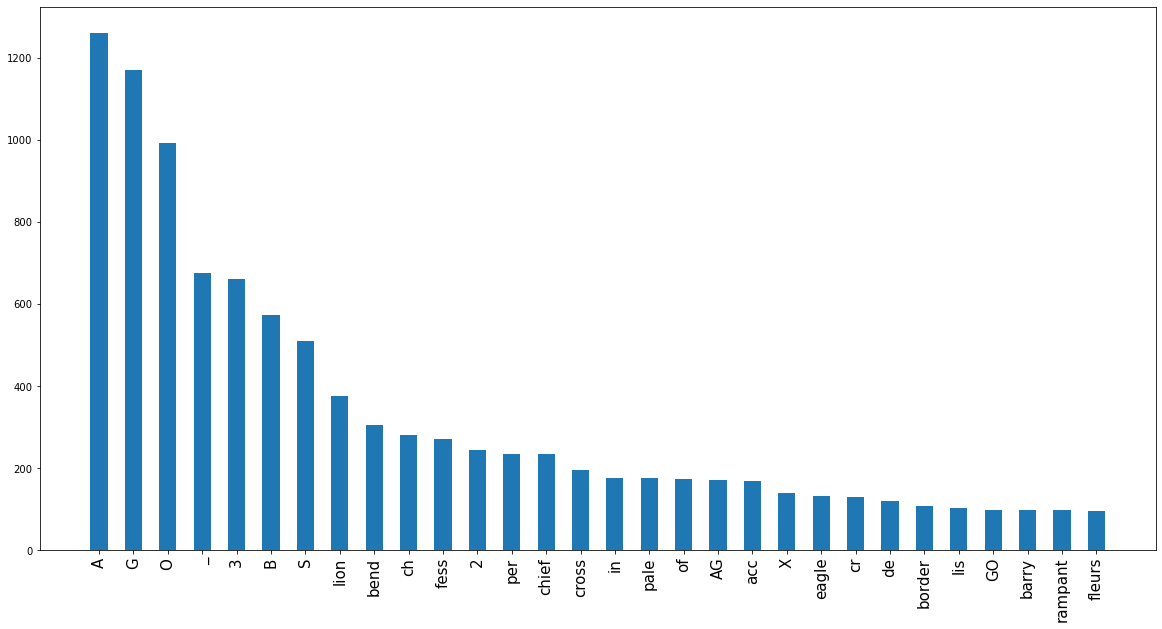

[('A', 1261),
 ('G', 1170),
 ('O', 992),
 ('_', 676),
 ('3', 661),
 ('B', 573),
 ('S', 510),
 ('lion', 375),
 ('bend', 304),
 ('ch', 281),
 ('fess', 271),
 ('2', 245),
 ('per', 235),
 ('chief', 234),
 ('cross', 196),
 ('in', 175),
 ('pale', 175),
 ('of', 174),
 ('AG', 171),
 ('acc', 170),
 ('X', 140),
 ('eagle', 133),
 ('cr', 131),
 ('de', 120),
 ('border', 108),
 ('lis', 103),
 ('GO', 97),
 ('barry', 97),
 ('rampant', 97),
 ('fleurs', 95)]

In [39]:

y = Counter(voc)
plot_bar_chart(y.most_common(30))
y.most_common(30)

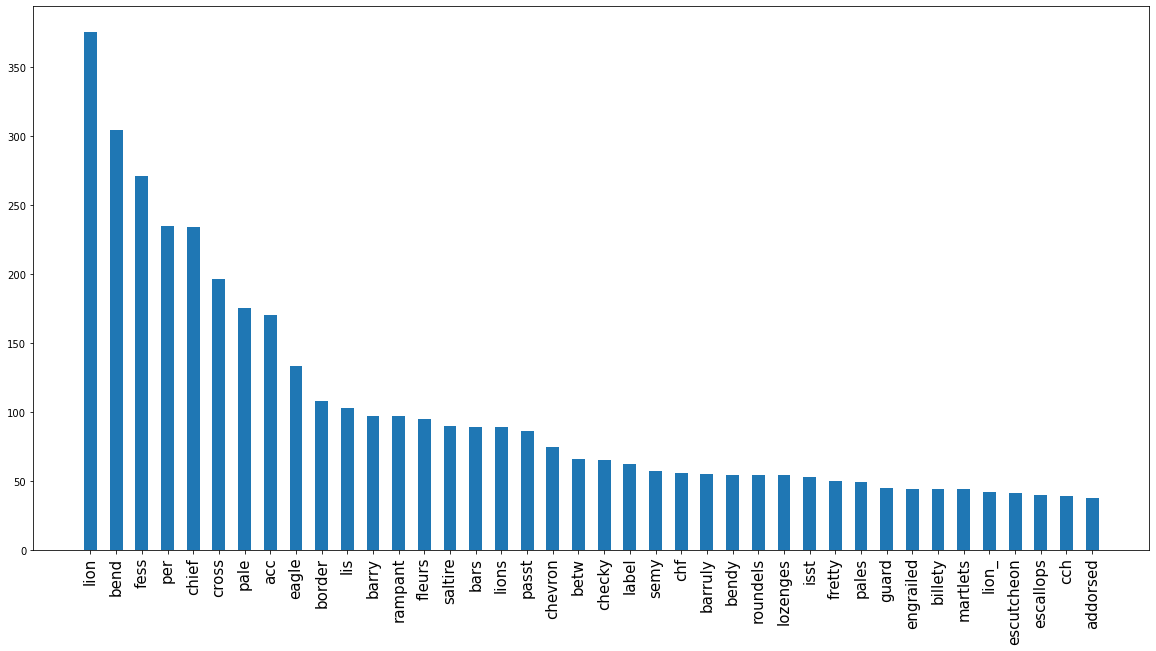

[('lion', 375),
 ('bend', 304),
 ('fess', 271),
 ('per', 235),
 ('chief', 234),
 ('cross', 196),
 ('pale', 175),
 ('acc', 170),
 ('eagle', 133),
 ('border', 108),
 ('lis', 103),
 ('barry', 97),
 ('rampant', 97),
 ('fleurs', 95),
 ('saltire', 90),
 ('bars', 89),
 ('lions', 89),
 ('passt', 86),
 ('chevron', 75),
 ('betw', 66),
 ('checky', 65),
 ('label', 62),
 ('semy', 57),
 ('chf', 56),
 ('barruly', 55),
 ('bendy', 54),
 ('roundels', 54),
 ('lozenges', 54),
 ('isst', 53),
 ('fretty', 50),
 ('pales', 49),
 ('guard', 45),
 ('engrailed', 44),
 ('billety', 44),
 ('martlets', 44),
 ('lion_', 42),
 ('escutcheon', 41),
 ('escallops', 40),
 ('cch', 39),
 ('addorsed', 38)]

In [38]:
cleaned_vocabularies_without_color = [l for l in voc if len(l)>2]

y = Counter(cleaned_vocabularies_without_color)
plot_bar_chart(y.most_common(40))
y.most_common(40)

## Check the folder and see. Many images for the same label however they are different. 
## There are wrong labeled data in the ground truth! :( 
It's visible via streamlit tool .. 

## Check if the labels match our simple automata 

In [62]:
captions_val = []
captions_val_armoria = []
for l in labels:
    c = Caption(l, support_plural=False)
    if c.is_valid:
        captions_val.append(l)
    if c.is_valid_in_armoria:
        captions_val_armoria.append(l)

print(f'Total number of valid labels in our automata {len(captions_val)} out of {len(labels)}' )
print(f'Total number of valid labels in our automata and Armoria API {len(captions_val_armoria)} out of {len(labels)}' )

# Total number of valid labels in our automata 907 out of 3065
# Total number of valid labels in our automata and Armoria API 271 out of 3065



No shield color found in this label: " lion_ bend_ =_ =   {BO, GO}"
No shield color found in this label: " lion_ fess  {OS, GA}"
No shield color found in this label: " lion_ castle   {AG, BO}"
Caption Class - exception in label O GS barry masoned of 4, ['masoned']
Caption Class - exception in label A G checky, ['checky']
Caption Class - exception in label B O 2 barbels addorsed, ['barbels']
Caption Class - exception in label A BG checky _ border, ['_']
Caption Class - exception in label A G checky of 9, ['checky']
Caption Class - exception in label A G lion_s head, ['lion_s']
Caption Class - exception in label G O bend engrailed, ['bend', 'engrailed']
Caption Class - exception in label A SO gironny, crusily, ['crusily']
Caption Class - exception in label O S talbot gorged, ['talbot']
No shield color found in this label: " bend ch. lion and 2 roses_ chief ch. 2 mullets_ =_ =   {GA, EGA}"
No shield color found in this label: " man cr. holding sword_ bend_ =_ =   {AGN, GA}"
Caption Class 

Caption Class - exception in label O S 3 yokes in pale, ['in']
Caption Class - exception in label A G per bend nebuly, ['per', 'bend']
Caption Class - exception in label A GB cup cloth-covered above mount, ['above']
Caption Class - exception in label B AG greyhound salient _ border, ['salient']
No shield color found in this label: " bend ch. 3 escallops_ 3 flanchis _ chief_ =_ =   {GBO , BOO}"
Caption Class - exception in label O G bend, ['bend']
Caption Class - exception in label B A bend, ['bend']
Caption Class - exception in label X A OG lozengy _ bendy, ['_']
No shield color found in this label: " pq[4 lions_ lozengy_ =_ =], tower   {AG, OG_ OS}"
Caption Class - exception in label G O bend, ['bend']
Caption Class - exception in label S O bend, ['bend']
Caption Class - exception in label G A bend, ['bend']
Caption Class - exception in label A BG bendy _ border, ['_']
Caption Class - exception in label A GG bend cotised(1), ['cotised(1)']
Caption Class - exception in label G AA chevr

Caption Class - exception in label A GS 2 ibex horns affronted on mount, ['affronted']
Caption Class - exception in label G O 2 barbels addorsed, ['barbels']
Caption Class - exception in label A S bend, ['bend']
Caption Class - exception in label S AA bend betw 6 martlets, ['betw']
Caption Class - exception in label S OV 2 flails addorsed acc. mount in base, ['addorsed', 'mount']
No shield color found in this label: " per pale_ barry _ chevron_ =_ =   {AG, XB-GA}"
Caption Class - exception in label S AG bend ch. 3 roundels, ['ch.']
No shield color found in this label: " bend_ bugle-horn stringed_ =_ = _E_ checky of 9  {GO, OB_ OB}"
Caption Class - exception in label  bend_ bugle-horn stringed_ =_ = _E_ checky of 9  {GO, OB_ OB}, ['bend_']
No shield color found in this label: " crayfish per bend_ 2 lions passt guard_ =_ =  {GA, OB}"
Caption Class - exception in label  crayfish per bend_ 2 lions passt guard_ =_ =  {GA, OB}, ['per']
Caption Class - exception in label A BO bend ch. 3 garbs

## Check if the labels match our plural automata 

In [61]:
captions_val = []
captions_val_armoria = []
for l in labels:
    c = Caption(l, support_plural=True)
    if c.is_valid:
        captions_val.append(l)
    if c.is_valid_in_armoria:
        captions_val_armoria.append(l)

print(f'Total number of valid labels in our automata {len(captions_val)} out of {len(labels)}' )
print(f'Total number of valid labels in our automata and Armoria API {len(captions_val_armoria)} out of {len(labels)}' )

# Total number of valid labels in our automata 1273 out of 3065
# Total number of valid labels in our automata and Armoria API 271 out of 3065



No shield color found in this label: " lion_ bend_ =_ =   {BO, GO}"
No shield color found in this label: " lion_ fess  {OS, GA}"
No shield color found in this label: " lion_ castle   {AG, BO}"
Caption Class - exception in label O GS barry masoned of 4, ['masoned']
Caption Class - exception in label A G checky, ['checky']
Caption Class - exception in label B O 2 barbels addorsed, ['barbels']
Caption Class - exception in label A BG checky _ border, ['_']
Caption Class - exception in label A G checky of 9, ['checky']
Caption Class - exception in label A G lion_s head, ['lion_s']
Caption Class - exception in label G O bend engrailed, ['bend', 'engrailed']
Caption Class - exception in label A SO gironny, crusily, ['crusily']
Caption Class - exception in label O S talbot gorged, ['talbot']
No shield color found in this label: " bend ch. lion and 2 roses_ chief ch. 2 mullets_ =_ =   {GA, EGA}"
No shield color found in this label: " man cr. holding sword_ bend_ =_ =   {AGN, GA}"
Caption Class 

No shield color found in this label: " barry acc. escutcheon _ chief paly and corners gironny_ cross_ =_ =  {BOA, OG}"
Caption Class - exception in label O S checky, ['checky']
Caption Class - exception in label G O checky, ['checky']
Caption Class - exception in label S O bend, ['bend']
Caption Class - exception in label S O 3 chicots in pale, ['in']
Caption Class - exception in label O S bend, ['bend']
Caption Class - exception in label B A bend engrailed, ['bend', 'engrailed']
No shield color found in this label: " barry_ semy of fleurs-de-lis  {AG, BO}"
Caption Class - exception in label O X AG bend vairy, ['vairy']
Caption Class - exception in label X E OG barry _ bend, ['_']
Caption Class - exception in label O G 2 wolves passt in pale, ['wolves', 'in']
Caption Class - exception in label O S bend, ['bend']
Caption Class - exception in label B O roundel, ['roundel']
No shield color found in this label: " eagle doubleheaded_ semy of fleurs-de-lis    {OS, BO}"
No shield color found 

Caption Class - exception in label G O bend, ['bend']
Caption Class - exception in label O SA bend fretty, ['fretty']
Caption Class - exception in label O BAG 5 towers (2_1_2) _ label compony, ['_']
Caption Class - exception in label O X GA 3 ibex horns compony in pale, ['horns', 'in']
Caption Class - exception in label O B 3 lozenges in bend, ['in']
Caption Class - exception in label A GO stag_s head acc. crozier per pale overall, ['head', 'crozier']
Caption Class - exception in label A S bend dancetty, ['bend', 'dancetty']
No shield color found in this label: " lion cr._ paly-bendy_ =_ =  {SO, AB}"
No shield color found in this label: " eagle isst_ pale ch. spearhead_ =_ =   {AG, SAS}"
Caption Class - exception in label  eagle isst_ pale ch. spearhead_ =_ =   {AG, SAS}, ['eagle']
Caption Class - exception in label O G pale, ['pale']
No shield color found in this label: " per bend key _ fish_ 2 crescents in fess addorsed_ =_ =    {GO, AB_ RO}"
No shield color found in this label: " Na

Caption Class - exception in label O G 3 crampons per pale, ['crampons']
Caption Class - exception in label B AO crescent, crusily, ['crusily']
No shield color found in this label: " 2 bars_ 3 bends_ =_ =  {GO, BA}"
Caption Class - exception in label G A pale, ['pale']
Caption Class - exception in label O B per bend nebuly sn, ['per', 'bend', 'nebuly']
No shield color found in this label: " checky of 9_ bear on mount_ =_ =   {AS, ASS}"
Caption Class - exception in label A SO bend ch. 3 escallops, ['ch.']
No shield color found in this label: " 3 chevrons crenelated_ shovel per bend_ =_ =   {AG, BO}"
Caption Class - exception in label B O 2 axes addorsed, ['axes']
Caption Class - exception in label O B bend engrailed, ['bend', 'engrailed']
Caption Class - exception in label O G human head with hat, ['human']
Caption Class - exception in label A S bull_s head, ['bull_s']
Caption Class - exception in label O V wolf_s head, ['wolf_s']
No shield color found in this label: " blackamoor_s head

## Double check again via automata directly

In [53]:
automata = LabelCheckerAutomata(support_plural=False)
validated_labels = automata.get_valid_labels(labels)

In [54]:
total = len(labels)
valid = len(validated_labels)
print('Total number of labels', total)
print('Valid labels', valid)
print('Invalid labels', total - valid)

Total number of labels 3065
Valid labels 907
Invalid labels 2158


In [72]:
# note that we have duplicate 362 labels!! using a dict vs list made that clear
900 - 538

362

In [75]:
captions = [ Caption(l, support_plural=False) for l in labels ]
print(len(captions))


3065


In [74]:
valid = [ 1 for c in captions if c.is_valid ]
sum(valid)

label "G A per chevron" cannot be parsed. The chunk "per" cannot be fit into any category.
label "S O 3 crosses formy" cannot be parsed. The chunk "formy" cannot be fit into any category.
label "A S crampon per fess" cannot be parsed. The chunk "crampon" cannot be fit into any category.
label "A S crampon per fess" cannot be parsed. The chunk "per" cannot be fit into any category.
label "B OX AG per bend lion _ 2 bars" cannot be parsed. The chunk "per" cannot be fit into any category.
label "B OX AG per bend lion _ 2 bars" cannot be parsed. The chunk "_" cannot be fit into any category.
label "G plain" cannot be parsed. The chunk "plain" cannot be fit into any category.
label " lion_ bend_ =_ =   {BO, GO}" cannot be parsed. The chunk "lion_" cannot be fit into any category.
label " lion_ bend_ =_ =   {BO, GO}" cannot be parsed. The chunk "bend_" cannot be fit into any category.
label " lion_ bend_ =_ =   {BO, GO}" cannot be parsed. The chunk "=_" cannot be fit into any category.
label 

label " tower, bust of man_ =_ =   {AG, AG}" cannot be parsed. The chunk "=" cannot be fit into any category.
label " tower, bust of man_ =_ =   {AG, AG}" cannot be parsed. The chunk "{AG," cannot be fit into any category.
label " tower, bust of man_ =_ =   {AG, AG}" cannot be parsed. The chunk "AG}" cannot be fit into any category.
label "O S per pale _ 2 antlers per pale cch" cannot be parsed. The chunk "per" cannot be fit into any category.
label "O S per pale _ 2 antlers per pale cch" cannot be parsed. The chunk "_" cannot be fit into any category.
label "O S per pale _ 2 antlers per pale cch" cannot be parsed. The chunk "per" cannot be fit into any category.
label "B AOG book betw 3 fleurs-de-lis and over all a bend" cannot be parsed. The chunk "book" cannot be fit into any category.
label "B AOG book betw 3 fleurs-de-lis and over all a bend" cannot be parsed. The chunk "over" cannot be fit into any category.
label "B AOG book betw 3 fleurs-de-lis and over all a bend" cannot be pa

label " wheel_ pq[lion guard_ lion_ =_ =]_ =_ =   {GA_ GA, AG}" cannot be parsed. The chunk "lion_" cannot be fit into any category.
label " wheel_ pq[lion guard_ lion_ =_ =]_ =_ =   {GA_ GA, AG}" cannot be parsed. The chunk "=_" cannot be fit into any category.
label " wheel_ pq[lion guard_ lion_ =_ =]_ =_ =   {GA_ GA, AG}" cannot be parsed. The chunk "=]_" cannot be fit into any category.
label " wheel_ pq[lion guard_ lion_ =_ =]_ =_ =   {GA_ GA, AG}" cannot be parsed. The chunk "=_" cannot be fit into any category.
label " wheel_ pq[lion guard_ lion_ =_ =]_ =_ =   {GA_ GA, AG}" cannot be parsed. The chunk "=" cannot be fit into any category.
label " wheel_ pq[lion guard_ lion_ =_ =]_ =_ =   {GA_ GA, AG}" cannot be parsed. The chunk "{GA_" cannot be fit into any category.
label " wheel_ pq[lion guard_ lion_ =_ =]_ =_ =   {GA_ GA, AG}" cannot be parsed. The chunk "GA," cannot be fit into any category.
label " wheel_ pq[lion guard_ lion_ =_ =]_ =_ =   {GA_ GA, AG}" cannot be parsed. Th

907

# get simple valid labels with lion

In [68]:
simple_automata = LabelCheckerAutomata(support_plural=False)
lion_labels = simple_automata.get_valid_labels_of(labels, 'lion')
print(len(lion_labels))
lion_labels

244


['O S lion rampant',
 'O B lion rampant',
 'G O lion passt guard',
 'O SG lion _ label',
 'A SG lion holding trunk',
 'A G lion rampant',
 'B A lion rampant',
 'O GS lion cr. _ border engrailed',
 'O G lion q.f.',
 'B AG chief ch. lion q.f.',
 'O G lion rampant',
 'A B lion rampant',
 'B X AG lion barruly cr.',
 'B A lion cr.',
 'A GB lion naissant cr. _ bend',
 'O B lion rampant',
 'A B lion rampant',
 'O GV lion naissant above mount',
 'A GV lion stat guard on mount',
 'B A lion cr.',
 'S OA lion acc. bend',
 'G A lion q.f.',
 'B O lion rampant',
 'B AOG fleur-de-lis _ chief ch. lion isst',
 'G OAB lion cr. _ border compony',
 'O SAG lion passt cr. _ border compony',
 'A SG lion _ label',
 'G O lion guard q.f.',
 'X G AB barruly _ lion cr.',
 'B O lion cr.',
 'A GV lion and eagle_s claw winged sn',
 'A G lion naissant cr.',
 'G O lion rampant',
 'A G lion cr.',
 'B A lion rampant',
 'G O lion q.f.',
 'G X AS lion checky cr.',
 'B AG lion naissant above mount',
 'A S lion rampant',
 '

In [69]:
plural_automata = LabelCheckerAutomata(support_plural=True)
lion_labels_p = plural_automata.get_valid_labels_of(labels, 'lion')
print(len(lion_labels_p))
lion_labels_p

317


['O S lion rampant',
 'O GG cross acc. 4 lions',
 'O B lion rampant',
 'G O lion passt guard',
 'A G 2 lions rampant addorsed',
 'O SG lion _ label',
 'A SG lion holding trunk',
 'A G lion rampant',
 'O B 3 lions passt cr.',
 'B A lion rampant',
 'G O 3 lions',
 'O GS lion cr. _ border engrailed',
 'O G lion q.f.',
 'G A 3 lions',
 'B AG chief ch. lion q.f.',
 'O G lion rampant',
 'A B lion rampant',
 'B X AG lion barruly cr.',
 'A GBA 9 hearts _ chief ch. lion passt cr.',
 'B A lion cr.',
 'A GB lion naissant cr. _ bend',
 'O S 3 lions',
 'O B lion rampant',
 'B O 3 lions',
 'A B lion rampant',
 'O GV lion naissant above mount',
 'A GV lion stat guard on mount',
 'B A lion cr.',
 'S OA lion acc. bend',
 'G A lion q.f.',
 'B O lion rampant',
 'B AOG fleur-de-lis _ chief ch. lion isst',
 'A XG AB 3 bars compony _ lion',
 'G OAB lion cr. _ border compony',
 'O SAG lion passt cr. _ border compony',
 'S O 2 lions passt guard',
 'A SG lion _ label',
 'G O lion guard q.f.',
 'X G AB barruly 

# get simple valid labels with cross

In [74]:
cross_labels = plural_automata.get_valid_labels_of(labels, 'cross')


In [75]:
print(len(cross_labels))
cross_labels

146


['G A cross',
 'A G cross patonce',
 'O B cross patriarchal',
 'X G BO per fess _ cross botonny',
 'O GG cross acc. 4 lions',
 'B O cross engrailed',
 'O BB cross patonce acc. 4 martlets',
 'O B cross engrailed',
 'O G cross engrailed',
 'O G cross',
 'G A+ castle _ chief {pp[Ar cross Gu_ Ar eagle Sa]}',
 'B O cross',
 'A G cross',
 'O G cross',
 'E G cross moline',
 'O SA cross fretty',
 'B OGO cross ch. 5 escallops, crusily',
 'B O cross potenty',
 'O G cross',
 'G E cross',
 'A SO cross fretty',
 'O A cross botonny',
 'O XBE GA cross ch. 5 escallops acc. 16 eagles _ label',
 'G AA escutcheon acc. orle of cross crosslets',
 'O G cross fleuretty',
 'G Z cross moline',
 'B AO cross and crozier sn',
 'A G cross moline',
 'O G cross moline',
 'B AG cross ch. 5 crescents',
 'A X SO cross lozengy',
 'G EA chevron betw 3 cross crosslets',
 'A G 5 lozenges per cross',
 'S A cross patonce',
 'A GSS chevron betw. 3 cross crosslets and martlet in chf dx',
 'A S cross',
 'G O cross formy',
 'A G

# get simple valid labels with eagle

In [76]:
eagle_labels = plural_automata.get_valid_labels_of(labels, 'eagle')


In [77]:
print(len(eagle_labels))
eagle_labels

111


['S O eagle',
 'S A eagle',
 'G O 3 eagles',
 'G O eagle',
 'O X GS eagle per pale',
 'G A eagle',
 'B X AG eagle checky cr.',
 'G A+ castle _ chief {pp[Ar cross Gu_ Ar eagle Sa]}',
 'A G eagle cr.',
 'O S eagle',
 'G A eagle cr.',
 'O XBE GA cross ch. 5 escallops acc. 16 eagles _ label',
 'B A eagle',
 'A G eagle',
 'A GV lion and eagle_s claw winged sn',
 'G A eagle doubleheaded',
 'B O eagle',
 'A G eagle doubleheaded',
 'A G dragon with eagle_s wings',
 'B O eagle',
 'S A eagle doubleheaded',
 'O S eagle doubleheaded',
 'O S eagle',
 'A G eagle',
 'A S eagle',
 'B O eagle cr.',
 'A B eagle doubleheaded',
 'G O eagle doubleheaded',
 'G A eagle',
 'O S eagle per fess',
 'A GO eagle ch. crescent',
 'O S 2 eagles in pale',
 'A X BG eagle per pale',
 'V O eagle',
 'G O eagle',
 'A S eagle',
 'O G eagle',
 ' cross_ eagle rising holding the hind-part of a lion passt_ =_ =   {GO, BAO}',
 'O SA eagle ch. crescent',
 'O SA eagle ch. crescent',
 'O GOB cross ch. 3 roundels acc. 16 eagles',
 '

In [67]:
elabels = simple_automata.get_valid_labels_of(labels, 'per pale')


In [83]:
print(len(elabels))
elabels

7


['O X GS eagle per pale',
 'S O bugle-horn stringed per pale',
 'O X AB chief per pale',
 'G X AS chevron per pale inv',
 'A X BG eagle per pale',
 'B X AG chief per pale',
 'B X AG chief per pale']